In [32]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import lightgbm as lgb
from sklearn.model_selection import GroupKFold

#最大表示列数の指定（ここでは50列を指定）
pd.set_option('display.max_columns', 50)

# 最大表示行数の指定（ここでは50行を指定）
pd.set_option('display.max_rows', 500)

In [2]:
train_df = pd.read_parquet('../data/feature_engineering_v5_train_df.parquet')
test_df = pd.read_parquet('../data/feature_engineering_v5_test_df.parquet')

train_label = pd.read_csv('../train_label.csv')
test_session = pd.read_csv('../test_session.csv')

In [3]:
train_df

,session_id,yado_no,target,seq_no,seen_yad,max_seq_no,diff_seq_no,is_odd,multiple_visits_flag,yad_type,total_room_cnt,wireless_lan_flg,onsen_flg,kd_stn_5min,kd_bch_5min,kd_slp_5min,kd_conv_walk_5min,wid_cd,ken_cd,lrg_cd,sml_cd,popularity,overall_rank,wid_cd_rank,ken_cd_rank,lrg_cd_rank,sml_cd_rank,label_wid_cd,label_ken_cd,label_lrg_cd,label_sml_cd,count_wid_cd,count_ken_cd,count_lrg_cd,count_sml_cd,count_yado_no,fold,TE_wid_cd_mean,TE_wid_cd_var,TE_ken_cd_mean,TE_ken_cd_var,TE_lrg_cd_mean,TE_lrg_cd_var,TE_sml_cd_mean,TE_sml_cd_var,TE_yado_no_mean,TE_yado_no_var
0,00063c614aca4920b965558ff79dd6c8,5583,1,0,1,1,1,0,0,0,55.0,-1.0,1,-1.0,-1.0,-1.0,-1.0,dc414a17890cfc17d011d5038b88ca93,223938a74a609968141867c244086206,63083678169dddaf76ddb92c6c6fdf65,33bfe292401fc7f99b8b9831a71f61ee,48.0,4508.0,555.0,94.0,45.0,35.0,4,5,5,5,11663,1870,659,534,8,0,0.840099,0.134347,0.795591,0.162735,0.827715,0.142870,0.804598,0.157582,1.000000,0.000000
1,0009f793074d5edb78b4e7471e494c9a,7178,1,0,1,1,1,0,0,0,206.0,1.0,0,1.0,-1.0,-1.0,1.0,321b69d5eec98fe6253e26b86058e6a9,0745a2107686fcb724892ce52f19d02e,5f6ef5263d833db9eb585c0b685e6817,749baed21736073c6b7b624cc76932ea,235.0,268.0,6.0,5.0,4.0,4.0,1,7,8,8,3075,1578,1052,1023,60,0,0.837816,0.135936,0.838247,0.135697,0.815348,0.150737,0.815043,0.150934,0.680851,0.222017
2,000a472a87af3fc9c16e5232d37da15a,12333,1,0,1,1,1,0,0,0,197.0,1.0,1,-1.0,-1.0,-1.0,1.0,321b69d5eec98fe6253e26b86058e6a9,0745a2107686fcb724892ce52f19d02e,bd9ca9b95bfc526f6ae521d5f4442362,1ed4e9cbfda3e66bc84c1392d75ef036,33.0,5904.0,183.0,92.0,20.0,5.0,1,7,9,9,3075,1578,332,79,7,0,0.837816,0.135936,0.838247,0.135697,0.911111,0.081289,0.950000,0.048305,1.000000,0.000000
3,000bbc7ab01813d008039b2c9195fe01,13079,0,0,1,1,1,0,0,0,261.0,1.0,0,1.0,-1.0,-1.0,1.0,b07b75d367ebece55a23ceecc939fff4,0a66f6ab9c0507059da6f22a0e1f1690,9ab5718fd88c6e5f9fec37a51827d428,7aff71bb47acb796d425c5ed5e6dfb3f,248.0,232.0,21.0,21.0,5.0,4.0,5,8,12,12,7932,7932,2151,1843,42,0,0.826593,0.143359,0.826593,0.143359,0.932370,0.063093,0.930801,0.064455,0.896552,0.096059
4,000f033450b5d9524a0d8c23bebda53c,12223,1,0,1,1,1,0,0,0,42.0,1.0,0,-1.0,-1.0,-1.0,1.0,c312e07b7a5d456d53a5b00910a336e1,543ea7c443fdfd779bbd557f2ad99d80,ad1d0da421776af5808aa4cb03ef0c1e,dbbf6f4fc947c0e61503740df4deab4d,61.0,3635.0,292.0,35.0,2.0,2.0,6,12,16,16,8853,924,87,78,16,0,0.818156,0.148798,0.840456,0.134281,0.909091,0.084175,0.897959,0.093537,0.700000,0.233333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109448,fff3eb89a3d1d6fd7ef1706c6b7bb102,7681,1,1,1,2,1,0,0,0,96.0,1.0,0,1.0,-1.0,-1.0,1.0,dc414a17890cfc17d011d5038b88ca93,d78f53d0856617bc782f02c3280dfef2,e5cfcc0a43c82072aca11628ff0add53,e2f51242791849e72240784844876b89,202.0,409.0,44.0,28.0,28.0,13.0,4,27,47,92,11663,4587,3247,1375,47,4,0.837864,0.135863,0.817434,0.149276,0.824913,0.144487,0.726201,0.199013,0.736842,0.199147
109449,fff77a0e60976a6208d1f0a94702d6b8,11634,1,0,1,1,1,0,0,0,215.0,1.0,0,1.0,-1.0,-1.0,1.0,43875109d1dab93592812c50d18270a7,3b09a7ce9934c00fd266f9cf246308d1,c0e203c17b3a418d089e96aac011d1a1,a5a49a911ded94700d282a1d4ff3a373,151.0,832.5,18.0,8.0,8.0,5.0,10,21,32,35,3132,1046,761,501,27,4,0.866100,0.116017,0.879268,0.106285,0.889267,0.098639,0.908136,0.083644,0.727273,0.207792
109450,fff92a0a11b20f1a6eb3b83a94f917ec,3473,1,0,1,1,1,0,0,0,126.0,1.0,0,1.0,-1.0,-1.0,1.0,dc414a17890cfc17d011d5038b88ca93,d78f53d0856617bc782f02c3280dfef2,145f05d14ef5eaee02ec4752a4d20482,af3c48f954de7e56a15bb71aed201575,122.0,1361.0,143.0,65.0,1.0,1.0,4,27,105,118,11663,4587,201,201,26,4,0.837864,0.135863,0.817434,0.149276,0.790850,0.166495,0.790850,0.166495,0.681818,0.227273
109451,fffaafbf1b7c08a586cfe2a73eec1f48,3634,1,0,1,1,1,0,0,0,158.0,1.0,0,-1.0,-1.0,-1.0,1.0,f0112abf369fb03cdc5f5309300913da,ce3aaf25e7e38a0c42d373fb148efc86,b94b1624f29aceb6511babed280db4d7,8cb854e17cd42e2b44f0c603da4608d4,65.0,3387.5,477

In [6]:
print(train_df['seen_yad'].value_counts())
print(test_df['seen_yad'].value_counts())

1    109453
Name: seen_yad, dtype: int64
1    63396
Name: seen_yad, dtype: int64


In [ ]:
# ver1では一旦無視
# Ranking学習の場合、Taregetの数字を変える
# 1を1に、0を2に変える
# train_label['target'] = train_label['target'].replace(0, 2)

### LightGBM Ranker（seen_yado用のRankerモデル）

In [7]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

# 特徴量とターゲットの定義
all_features = train_df.columns.to_list()
features= [x for x in all_features if x not in ('session_id', 'fold', 'target', 'wid_cd', 'ken_cd', 'lrg_cd', 'sml_cd', 'seen_yad')] # seen_yadも入れる
target = 'target'  # ターゲット変数の列名
query_ids =  'session_id' #train_df['session_id'].values  # クエリIDの列名

# LightGBM のパラメータ
params = {
    'objective': 'lambdarank',
    'metric': 'map',
    'eval_at': [3, 5, 10],
    # 'label_gain':"0,1,5",　# ここを指定すると、ターゲットの重み付けができる　https://blog.recruit.co.jp/data/articles/lgbm_rank/
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'n_estimators' : 10000,
    'num_leaves': 31,
    'max_depth': -1,
    'seed': 42531,
}

In [9]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.metrics import label_ranking_average_precision_score

map_scores = []  # 各foldのMAPスコアを保存するリスト
test_pred = []   # 各foldのテストデータの予測値を保存するリスト
oof_pred = np.zeros(len(train_df))  # OOF予測値用の配列を初期化

for fold in range(5):
    # トレーニングデータとバリデーションデータの分割
    train_data = train_df[train_df['fold'] != fold]
    valid_data = train_df[train_df['fold'] == fold]

    # クエリごとのデータポイント数を計算
    train_groups = train_data.groupby(query_ids).size().values
    val_groups = valid_data.groupby(query_ids).size().values

    # LightGBMデータセットを作成
    lgb_train = lgb.Dataset(train_data[features], label=train_data[target], group=train_groups)
    lgb_val = lgb.Dataset(valid_data[features], label=valid_data[target], group=val_groups)

    # モデルの訓練
    model = lgb.train(params, lgb_train, valid_sets=[lgb_val], early_stopping_rounds=100, verbose_eval=1)

    # バリデーションデータでの予測と評価
    valid_pred = model.predict(valid_data[features])
    oof_pred[valid_data.index] = valid_pred  # OOF予測値の保存
    
    # MAPスコアの計算
    map_score = label_ranking_average_precision_score([valid_data[target].values], [valid_pred])
    map_scores.append(map_score)
    print(f'Fold {fold}: MAP = {map_score}')

    # テストデータでの予測
    test_pred.append(model.predict(test_df[features]))

# 平均 MAP の計算
print(f'Mean MAP: {np.mean(map_scores)}')

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 82650, total data: 87562
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5045
[LightGBM] [Info] Number of data points in the train set: 87562, number of used features: 39
[LightGBM] [Info] Total groups: 20662, total data: 21891
[1]	valid_0's map@3: 0.988151	valid_0's map@5: 0.988163	valid_0's map@10: 0.988163
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@3: 0.988578	valid_0's map@5: 0.98859	valid_0's map@10: 0.98859
[3]	valid_0's map@3: 0.988118	valid_0's map@5: 0.98813	valid_0's map@10: 0.98813
[4]	valid_0's map@3: 0.988409	valid_0's map@5: 0.988409	valid_0's map@10: 0.988409
[5]	valid_0's map@3: 0.988151	valid_0's map@5: 0.988151	valid_0's map@10: 0.988151
[6]	valid_0's map@3: 0.988102	valid_0's map@5: 0.988102	v

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 82649, total data: 87562
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5052
[LightGBM] [Info] Number of data points in the train set: 87562, number of used features: 39
[LightGBM] [Info] Total groups: 20663, total data: 21891
[1]	valid_0's map@3: 0.989434	valid_0's map@5: 0.989434	valid_0's map@10: 0.989434
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@3: 0.988998	valid_0's map@5: 0.988998	valid_0's map@10: 0.988998
[3]	valid_0's map@3: 0.988675	valid_0's map@5: 0.988675	valid_0's map@10: 0.988675
[4]	valid_0's map@3: 0.988595	valid_0's map@5: 0.988595	valid_0's map@10: 0.988595
[5]	valid_0's map@3: 0.988934	valid_0's map@5: 0.988934	valid_0's map@10: 0.988934
[6]	valid_0's map@3: 0.988917	valid_0's map@5: 0.988917	valid_0's map@10: 0.988917
[7]	valid_0's map@3: 0.988845	vali

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 82649, total data: 87562
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018984 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5056
[LightGBM] [Info] Number of data points in the train set: 87562, number of used features: 39
[LightGBM] [Info] Total groups: 20663, total data: 21891
[1]	valid_0's map@3: 0.989055	valid_0's map@5: 0.989055	valid_0's map@10: 0.989055
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@3: 0.988506	valid_0's map@5: 0.988506	valid_0's map@10: 0.988506
[3]	valid_0's map@3: 0.988433	valid_0's map@5: 0.988433	valid_0's map@10: 0.988433
[4]	valid_0's map@3: 0.988579	valid_0's map@5: 0.988579	valid_0's map@10: 0.988579
[5]	valid_0's map@3: 0.988724	valid_0's map@5: 0.988724	valid_0's map@10: 0.988724
[6]	valid_0's map@3: 0.988877	valid_0's map@5: 0.9888

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 82650, total data: 87563
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5042
[LightGBM] [Info] Number of data points in the train set: 87563, number of used features: 39
[LightGBM] [Info] Total groups: 20662, total data: 21890
[1]	valid_0's map@3: 0.988675	valid_0's map@5: 0.988687	valid_0's map@10: 0.988687
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@3: 0.98857	valid_0's map@5: 0.988582	valid_0's map@10: 0.988582
[3]	valid_0's map@3: 0.988159	valid_0's map@5: 0.988171	valid_0's map@10: 0.988171
[4]	valid_0's map@3: 0.987642	valid_0's map@5: 0.987654	valid_0's map@10: 0.987654
[5]	valid_0's map@3: 0.987626	valid_0's map@5: 0.987638	valid_0's map@10: 0.987638
[6]	valid_0's map@3: 0.988296	valid_0's map@5: 0.988296	valid_0's map@10: 0.988296
[7]	valid_0's map@3: 0.98832	valid_

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 82650, total data: 87563
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5047
[LightGBM] [Info] Number of data points in the train set: 87563, number of used features: 39
[LightGBM] [Info] Total groups: 20662, total data: 21890
[1]	valid_0's map@3: 0.989086	valid_0's map@5: 0.989098	valid_0's map@10: 0.989098
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@3: 0.988909	valid_0's map@5: 0.988921	valid_0's map@10: 0.988921
[3]	valid_0's map@3: 0.988788	valid_0's map@5: 0.9888	valid_0's map@10: 0.9888
[4]	valid_0's map@3: 0.98882	valid_0's map@5: 0.988832	valid_0's map@10: 0.988832
[5]	valid_0's map@3: 0.988772	valid_0's map@5: 0.988784	valid_0's map@10: 0.988784
[6]	valid_0's map@3: 0.988788	valid_0's map@5: 0.9888	vali

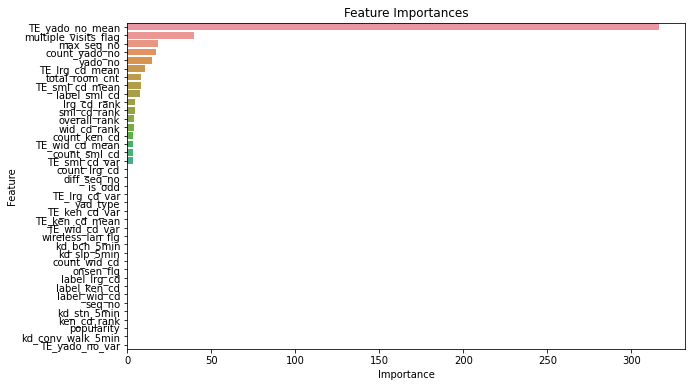

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# 特徴量重要度の取得
feature_importances = model.feature_importance(importance_type='gain')

# 特徴量名とその重要度を DataFrame に変換
feature_importance_df = pd.DataFrame({
    'feature': features,
    'importance': feature_importances
})

# 重要度で降順にソート
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# 特徴量重要度のプロット
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [11]:
train_df['oof_pred'] = oof_pred
train_df[['session_id', 'yado_no', 'oof_pred']].head()

,session_id,yado_no,oof_pred
0,00063c614aca4920b965558ff79dd6c8,5583,0.127967
1,0009f793074d5edb78b4e7471e494c9a,7178,-0.104211
2,000a472a87af3fc9c16e5232d37da15a,12333,0.150683
3,000bbc7ab01813d008039b2c9195fe01,13079,0.079229
4,000f033450b5d9524a0d8c23bebda53c,12223,-0.070878


### candidate_ver15_trainと結合

In [173]:
candidate_ver15_train = pd.read_csv('../data/candidate_ver15_train.csv')

In [174]:
train_label

,session_id,yad_no
0,000007603d533d30453cc45d0f3d119f,4101
1,0000ca043ed437a1472c9d1d154eb49b,8253
2,0000d4835cf113316fe447e2f80ba1c8,4863
3,0000fcda1ae1b2f431e55a7075d1f500,1652
4,000104bdffaaad1a1e0a9ebacf585f33,96
...,...,...
288693,ffff2262d38abdeb247ebd591835dcc9,2259
288694,ffff2360540745117193ecadcdc06538,963
288695,ffff7fb4617164b2604aaf51c40bf82d,13719
288696,ffffcd5bc19d62cad5a3815c87818d83,10619


In [175]:
# train_lebelとcandidate_ver15_trainをマージ
candidate_ver15_train = pd.concat([train_label['session_id'], candidate_ver15_train], axis=1)
candidate_ver15_train

,session_id,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,000007603d533d30453cc45d0f3d119f,11882,2808,5289,4101,3324,12846,997,9207,9209,9208
1,0000ca043ed437a1472c9d1d154eb49b,8253,8747,2570,1586,11104,3725,4488,2259,3564,8225
2,0000d4835cf113316fe447e2f80ba1c8,9039,6722,7509,4355,4863,11724,5238,13642,1967,2957
3,0000fcda1ae1b2f431e55a7075d1f500,626,755,11715,7812,109,2272,13296,1341,13549,7872
4,000104bdffaaad1a1e0a9ebacf585f33,96,3894,7749,902,11380,5490,1284,12491,254,4072
...,...,...,...,...,...,...,...,...,...,...,...
288693,ffff2262d38abdeb247ebd591835dcc9,13210,13079,2876,3725,8677,13717,1586,10955,10522,5719
288694,ffff2360540745117193ecadcdc06538,8703,3940,399,4767,2900,6654,5299,8465,963,513
288695,ffff7fb4617164b2604aaf51c40bf82d,7308,12240,4040,7820,4398,2087,9558,3566,844,10364
288696,ffffcd5bc19d62cad5a3815c87818d83,10619,570,12500,11091,7551,3238,10616,12781,12829,11316


In [176]:
candidate_ver15_train[candidate_ver15_train['session_id'] == '0034a87cb9efdc4c3e626edff7a62a0b']

,session_id,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
254,0034a87cb9efdc4c3e626edff7a62a0b,10933,1566,514,8494,5832,3274,13646,9124,9806,11780


In [177]:
#train_df[train_df['max_seq_no']>1][['session_id', 'yado_no', 'oof_pred']].head(10)
train_df[['session_id', 'yado_no', 'oof_pred']].head(10)

,session_id,yado_no,oof_pred
0,00063c614aca4920b965558ff79dd6c8,5583,0.127967
1,0009f793074d5edb78b4e7471e494c9a,7178,-0.104211
2,000a472a87af3fc9c16e5232d37da15a,12333,0.150683
3,000bbc7ab01813d008039b2c9195fe01,13079,0.079229
4,000f033450b5d9524a0d8c23bebda53c,12223,-0.070878
5,0015fad8cdfd8fc6a7fac6ed9ee7ec35,2482,0.106276
6,0016d4f0b2d46c639121e7061aaac2ab,3485,0.079229
7,0017de096b9c52673d290bedbd6519f6,10739,0.041501
8,001a480dfddc332c7c5525ac9b672049,11634,-0.104211
9,001b16bad48db55a598aabc1fda8d49a,3403,0.106276


In [178]:
import pandas as pd
from tqdm.auto import tqdm

# pandasのapplyにtqdmのプログレスバーを使用するための設定
tqdm.pandas()

# データフレームを読み込む
#condidate_ver15_train = pd.read_csv('condidate_ver15_train.csvのパス')
#train_df = pd.read_csv('train_df.csvのパス')

# oof_pred の値を簡単に検索するための辞書を作成
oof_pred_dict = train_df.set_index(['session_id', 'yado_no']).to_dict()['oof_pred']

# oof_pred に基づいて予測をソートする関数を定義
def sort_predictions(row):
    # session_id を抽出
    session_id = row['session_id']
    
    # oof_pred スコアを含む宿のリストを作成
    accomms_with_scores = [
        (accommodation, oof_pred_dict.get((session_id, accommodation), float('-inf')))
        for accommodation in row[predict_columns]
    ]
    
    # スコアの降順に宿をソート
    sorted_accomms_with_scores = sorted(accomms_with_scores, key=lambda x: x[1], reverse=True)
    
    # ソートされた宿を抽出
    sorted_accomms = [accommodation for accommodation, score in sorted_accomms_with_scores]
    
    # 行をソートされた宿で更新
    row[predict_columns] = sorted_accomms
    return row

# 宿の予測を含む列
predict_columns = [f'predict_{i}' for i in range(10)]

# candidate データフレームの各行に対してソート関数を適用
# tqdmを使用してプログレスバーを表示
new_candidate_ver15_train = candidate_ver15_train.progress_apply(sort_predictions, axis=1)



  0%|          | 0/288698 [00:00<?, ?it/s]

In [179]:
candidate_ver15_train

,session_id,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,000007603d533d30453cc45d0f3d119f,11882,2808,5289,4101,3324,12846,997,9207,9209,9208
1,0000ca043ed437a1472c9d1d154eb49b,8253,8747,2570,1586,11104,3725,4488,2259,3564,8225
2,0000d4835cf113316fe447e2f80ba1c8,9039,6722,7509,4355,4863,11724,5238,13642,1967,2957
3,0000fcda1ae1b2f431e55a7075d1f500,626,755,11715,7812,109,2272,13296,1341,13549,7872
4,000104bdffaaad1a1e0a9ebacf585f33,96,3894,7749,902,11380,5490,1284,12491,254,4072
...,...,...,...,...,...,...,...,...,...,...,...
288693,ffff2262d38abdeb247ebd591835dcc9,13210,13079,2876,3725,8677,13717,1586,10955,10522,5719
288694,ffff2360540745117193ecadcdc06538,8703,3940,399,4767,2900,6654,5299,8465,963,513
288695,ffff7fb4617164b2604aaf51c40bf82d,7308,12240,4040,7820,4398,2087,9558,3566,844,10364
288696,ffffcd5bc19d62cad5a3815c87818d83,10619,570,12500,11091,7551,3238,10616,12781,12829,11316


In [180]:
new_candidate_ver15_train

,session_id,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,000007603d533d30453cc45d0f3d119f,11882,2808,5289,4101,3324,12846,997,9207,9209,9208
1,0000ca043ed437a1472c9d1d154eb49b,8253,8747,2570,1586,11104,3725,4488,2259,3564,8225
2,0000d4835cf113316fe447e2f80ba1c8,9039,6722,7509,4355,4863,11724,5238,13642,1967,2957
3,0000fcda1ae1b2f431e55a7075d1f500,626,755,11715,7812,109,2272,13296,1341,13549,7872
4,000104bdffaaad1a1e0a9ebacf585f33,96,3894,7749,902,11380,5490,1284,12491,254,4072
...,...,...,...,...,...,...,...,...,...,...,...
288693,ffff2262d38abdeb247ebd591835dcc9,13210,13079,2876,3725,8677,13717,1586,10955,10522,5719
288694,ffff2360540745117193ecadcdc06538,8703,3940,399,4767,2900,6654,5299,8465,963,513
288695,ffff7fb4617164b2604aaf51c40bf82d,7308,12240,4040,7820,4398,2087,9558,3566,844,10364
288696,ffffcd5bc19d62cad5a3815c87818d83,10619,570,12500,11091,7551,3238,10616,12781,12829,11316


In [ ]:
# もう少し深堀たい（どういう順位変動が起こっているのか？？？）
# もう少し深堀たい（どういう順位変動が起こっているのか？？？）
# もう少し深堀たい（どういう順位変動が起こっているのか？？？）

In [181]:
# 各要素が一致しているかどうかをチェック
diff = candidate_ver15_train != new_candidate_ver15_train

# 一致していない行のインデックスを抽出
mismatched_indices = diff.any(axis=1)
mismatched_rows = candidate_ver15_train[mismatched_indices]

print("一致していない行のインデックス：")
print(mismatched_indices)
print("一致していない行：")
print(mismatched_rows)

一致していない行のインデックス：
0         False
1         False
2         False
3         False
4         False
          ...  
288693    False
288694    False
288695    False
288696    False
288697    False
Length: 288698, dtype: bool
一致していない行：
                              session_id  predict_0  predict_1  predict_2  \
150     001e95015b21d4d6bafe27011ef20582        532       3338       4913   
263     00354fb3eaafa4d5834fe7a25d97d9d7       3848       8553       3338   
358     004980de0ecd75a1f0bb794518e0dedd       7600       1383        640   
598     007e4eb2c163fac20f0b182eab0be1d0       5149       4215       9695   
835     00b1a510816774abd7f2948148a95143       4406      13523       6649   
...                                  ...        ...        ...        ...   
288224  ff9ab519bf4d73ed1281b241b49be102      13468        915      12350   
288233  ff9d70dcc788230cc9c16694ecc62057      13688       5867       4185   
288243  ff9fc5c2faa1a2dd2d01bd7ea8669774       2451       9959       9422   

In [182]:
candidate_ver15_train[mismatched_indices].head(20)

,session_id,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
150,001e95015b21d4d6bafe27011ef20582,532,3338,4913,3848,12350,13468,915,3694,1091,5948
263,00354fb3eaafa4d5834fe7a25d97d9d7,3848,8553,3338,915,13468,532,10118,4913,10175,1091
358,004980de0ecd75a1f0bb794518e0dedd,7600,1383,640,9780,144,6826,800,2759,11287,8508
598,007e4eb2c163fac20f0b182eab0be1d0,5149,4215,9695,12411,11181,4435,10941,5092,12737,7632
835,00b1a510816774abd7f2948148a95143,4406,13523,6649,2072,8912,5963,12642,11142,7946,4357
1072,00eaac06f0d5aa305c16ee6155e18259,1553,5952,1547,4544,6055,1018,6960,9613,13699,10586
1434,0138b8d9605b3c5eac86853bc37d1805,13137,13555,12375,952,8016,5609,1651,6651,11519,11208
1559,01541ac960c196bf3f4d6729a06f9cc3,13468,10118,3338,12350,532,8553,3848,4913,10175,1091
1602,015eaa599f7f147d2023f4d65e795a37,12961,10893,3697,7227,2870,5583,10417,4661,9359,9251
1890,01a3c640830d68d17c87cc66790451b9,6292,7914,12543,1954,1866,1920,5287,11394,4032,5891


In [183]:
new_candidate_ver15_train[mismatched_indices].head(20)

,session_id,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
150,001e95015b21d4d6bafe27011ef20582,3338,532,4913,3848,12350,13468,915,3694,1091,5948
263,00354fb3eaafa4d5834fe7a25d97d9d7,8553,3848,3338,915,13468,532,10118,4913,10175,1091
358,004980de0ecd75a1f0bb794518e0dedd,1383,7600,640,9780,144,6826,800,2759,11287,8508
598,007e4eb2c163fac20f0b182eab0be1d0,4215,5149,9695,12411,11181,4435,10941,5092,12737,7632
835,00b1a510816774abd7f2948148a95143,13523,4406,6649,2072,8912,5963,12642,11142,7946,4357
1072,00eaac06f0d5aa305c16ee6155e18259,5952,1553,1547,4544,6055,1018,6960,9613,13699,10586
1434,0138b8d9605b3c5eac86853bc37d1805,13555,13137,12375,952,8016,5609,1651,6651,11519,11208
1559,01541ac960c196bf3f4d6729a06f9cc3,10118,13468,3338,12350,532,8553,3848,4913,10175,1091
1602,015eaa599f7f147d2023f4d65e795a37,10893,12961,3697,7227,2870,5583,10417,4661,9359,9251
1890,01a3c640830d68d17c87cc66790451b9,7914,6292,12543,1954,1866,1920,5287,11394,4032,5891


In [184]:
# result_df = candidate_ver15_train
result_df = new_candidate_ver15_train

In [185]:
y_true = train_label['yad_no'].values.reshape(-1, 1)
y_pred = result_df.drop(columns=['session_id']).values

In [186]:
# Recall(候補にあげたものが)のy_trueに含まれているものの割合

# マッチするかどうかをチェックするリストを初期化
matches = []

# y_pred の各サブアレイと y_true の値を比較
for pred, true in zip(y_pred, y_true):
    # pred はサブアレイ、true は値
    matches.append(int(true in pred))

# matches は、指定された条件に基づいて 0 と 1 のリストです
print(matches)

# matches は先のステップで生成した 0 と 1 のリストです。
# 1 の割合を計算
one_ratio = sum(matches) / len(matches)

# 割合をプリント
print("Recall is: {:.2%}".format(one_ratio))

[1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 

In [187]:
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the AP at k between two lists of items.
    """
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean AP at k between two lists of list of items.
    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

# y_true と y_pred をリストに変換
y_true_list = [list(x) for x in y_true]
y_pred_list = [list(x) for x in y_pred]

# MAP@10 を計算
map_at_10 = mapk(y_true_list, y_pred_list, k=10)
print(f'Map@10  {map_at_10}')

Map@10  0.42307236501437706


In [188]:
result_df = candidate_ver15_train

In [189]:
# 各行内で重複があるかどうかをチェック
def check_row_duplicates(row):
    # setを用いてユニークな要素のみを抽出し、その長さが元の行の長さと等しいかを比較
    return len(row) != len(set(row))
# check_row_duplicates関数を各行に適用し、結果を新しい列に格納
result_df['has_duplicates'] = result_df.apply(check_row_duplicates, axis=1)
# 重複がある行のみをフィルタリング
rows_with_duplicates = result_df[result_df['has_duplicates']]
# 結果を表示
print(len(rows_with_duplicates))

0


### 予測ファイルの作成

In [204]:
print(np.mean(test_pred, axis=0))  # 各foldのテストデータの予測値の平均をとる
print(len(np.mean(test_pred, axis=0)))

[ 0.12217886 -0.05043758  0.03118109 ...  0.01779757 -0.02667497
 -0.08736205]
63396


In [205]:
test_df['target'] = np.mean(test_pred, axis=0)
test_df[['session_id', 'yado_no', 'target']].head()

,session_id,yado_no,target
0,00001149e9c73985425197104712478c,3560,0.122179
1,0000f17ae2628237d78d3a38b009d3be,757,-0.050438
2,000174a6f7a569b84c5575760d2e9664,12341,0.031181
3,0002f6aa27bcf984eeb3cf07297a96a9,10904,0.199135
4,0003f18c0c221438a9f90a5f6a4e9330,12986,0.059413


In [206]:
candidate_ver15_test = pd.read_csv('../data/candidate_ver15_test.csv')

In [207]:
test_df.head()

,session_id,yado_no,target,seq_no,seen_yad,max_seq_no,diff_seq_no,is_odd,multiple_visits_flag,yad_type,total_room_cnt,wireless_lan_flg,onsen_flg,kd_stn_5min,kd_bch_5min,kd_slp_5min,kd_conv_walk_5min,wid_cd,ken_cd,lrg_cd,sml_cd,popularity,overall_rank,wid_cd_rank,ken_cd_rank,lrg_cd_rank,sml_cd_rank,label_wid_cd,label_ken_cd,label_lrg_cd,label_sml_cd,count_wid_cd,count_ken_cd,count_lrg_cd,count_sml_cd,count_yado_no,TE_wid_cd_mean,TE_wid_cd_var,TE_ken_cd_mean,TE_ken_cd_var,TE_lrg_cd_mean,TE_lrg_cd_var,TE_sml_cd_mean,TE_sml_cd_var,TE_yado_no_mean,TE_yado_no_var
0,00001149e9c73985425197104712478c,3560,0.122179,0,1,1,1,0,0,0,205.0,1.0,0,-1.0,-1.0,-1.0,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,52ca3d2824fc3cc90bd4274423badeed,87d9490219b3778f73c41b8176cf30d0,86.0,2418.5,588.0,339.0,22.0,10.0,2,16,33,36,29070,12836,931,321,14.0,0.728277,0.197897,0.817077,0.149474,0.738990,0.193091,0.887850,0.099883,0.928571,0.071429
1,0000f17ae2628237d78d3a38b009d3be,757,-0.050438,0,1,1,1,0,0,0,174.0,1.0,0,1.0,-1.0,-1.0,1.0,f0112abf369fb03cdc5f5309300913da,bd054cc265d68a400ccb976ac69c6463,dca13b5f308a0ae88ab8875a9ab56919,3267093e6bcad4a46af9d3e46350b22f,135.0,1096.5,163.0,47.0,3.0,3.0,8,11,121,141,16080,3505,258,209,20.0,0.789179,0.166386,0.842796,0.132529,0.798450,0.161554,0.822967,0.146393,0.800000,0.168421
2,000174a6f7a569b84c5575760d2e9664,12341,0.031181,1,1,2,1,0,0,0,237.0,1.0,1,-1.0,-1.0,-1.0,1.0,d86102dd9c232bade9a97dccad40df48,acb04522bdbc0582bf16a6a97567cc27,57b6663bea1ed3527b11e80be82d5235,a5e1136fd4ebaa1dd055df0a44841538,202.0,409.0,16.0,2.0,1.0,1.0,9,24,36,39,6415,1126,376,376,33.0,0.840062,0.134379,0.812611,0.152410,0.816489,0.150234,0.816489,0.150234,0.757576,0.189394
3,0002f6aa27bcf984eeb3cf07297a96a9,10904,0.199135,0,1,1,1,0,0,0,56.0,1.0,1,-1.0,-1.0,-1.0,-1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,d944a4adb81c65f0392a8a273606ba72,0af2cfba7130b2b6ab8c227d3d948156,23.0,7189.5,1434.0,819.0,5.0,5.0,2,16,181,238,29070,12836,28,28,1.0,0.728277,0.197897,0.817077,0.149474,0.964286,0.035714,0.964286,0.035714,1.000000,NaN
4,0003f18c0c221438a9f90a5f6a4e9330,12986,0.059413,1,1,2,1,0,0,0,201.0,1.0,0,1.0,-1.0,-1.0,1.0,46e33861f921c3e38b81998fbf283f01,c86352f5b57e80fe545cfec1fd8505a1,9d6a46da05976cab8ac2b8583215c665,568887ea1e1d8c3cf3c60b5be585aa6d,345.0,96.0,49.0,14.0,10.0,7.0,2,6,7,7,29070,6716,3470,2561,83.0,0.728277,0.197897,0.727367,0.198334,0.693084,0.212780,0.732917,0.195826,0.891566,0.097855


In [208]:
test_session

,session_id
0,00001149e9c73985425197104712478c
1,0000e02747d749a52b7736dfa751e258
2,0000f17ae2628237d78d3a38b009d3be
3,000174a6f7a569b84c5575760d2e9664
4,00017e2a527901c9c41b1acef525d016
...,...
174695,fffee3199ef94b92283239cd5e3534fa
174696,ffff62c6bb49bc9c0fbcf08494a4869c
174697,ffff9a7dcc892875c7a8b821fa436228
174698,ffffb1d30300fe17f661941fd085b04b


In [209]:
# train_lebelとcandidate_ver15_trainをマージ
candidate_ver15_test = pd.concat([test_session['session_id'], candidate_ver15_test], axis=1)
candidate_ver15_test

,session_id,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,00001149e9c73985425197104712478c,3560,11561,4714,2680,4420,5466,9830,9534,6563,5785
1,0000e02747d749a52b7736dfa751e258,143,4066,6555,7014,11923,8108,6129,613,11237,12862
2,0000f17ae2628237d78d3a38b009d3be,757,9190,7710,1774,9910,10485,6721,410,13570,6730
3,000174a6f7a569b84c5575760d2e9664,12341,3359,6991,1542,13521,5080,10861,4180,10746,6489
4,00017e2a527901c9c41b1acef525d016,9020,2862,10826,12029,3854,3476,9623,3844,5372,6161
...,...,...,...,...,...,...,...,...,...,...,...
174695,fffee3199ef94b92283239cd5e3534fa,1997,7888,5744,11123,10997,7062,9743,2278,10042,3440
174696,ffff62c6bb49bc9c0fbcf08494a4869c,13220,12432,899,4014,3802,1227,3644,2164,13702,9723
174697,ffff9a7dcc892875c7a8b821fa436228,13241,13797,13719,12939,7308,2087,8143,11796,11037,5810
174698,ffffb1d30300fe17f661941fd085b04b,3100,10287,3002,2373,12281,4976,13672,2692,5513,1687


In [210]:
import pandas as pd
from tqdm.auto import tqdm

# pandasのapplyにtqdmのプログレスバーを使用するための設定
tqdm.pandas()

# oof_pred の値を簡単に検索するための辞書を作成
oof_pred_dict = test_df.set_index(['session_id', 'yado_no']).to_dict()['target']

# oof_pred に基づいて予測をソートする関数を定義
def sort_predictions(row):
    # session_id を抽出
    session_id = row['session_id']
    
    # oof_pred スコアを含む宿のリストを作成
    accomms_with_scores = [
        (accommodation, oof_pred_dict.get((session_id, accommodation), float('-inf')))
        for accommodation in row[predict_columns]
    ]
    
    # スコアの降順に宿をソート
    sorted_accomms_with_scores = sorted(accomms_with_scores, key=lambda x: x[1], reverse=True)
    
    # ソートされた宿を抽出
    sorted_accomms = [accommodation for accommodation, score in sorted_accomms_with_scores]
    
    # 行をソートされた宿で更新
    row[predict_columns] = sorted_accomms
    return row

# 宿の予測を含む列
predict_columns = [f'predict_{i}' for i in range(10)]

# candidate データフレームの各行に対してソート関数を適用
# tqdmを使用してプログレスバーを表示
new_candidate_ver15_test = candidate_ver15_test.progress_apply(sort_predictions, axis=1)

  0%|          | 0/174700 [00:00<?, ?it/s]

In [211]:
candidate_ver15_test

,session_id,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,00001149e9c73985425197104712478c,3560,11561,4714,2680,4420,5466,9830,9534,6563,5785
1,0000e02747d749a52b7736dfa751e258,143,4066,6555,7014,11923,8108,6129,613,11237,12862
2,0000f17ae2628237d78d3a38b009d3be,757,9190,7710,1774,9910,10485,6721,410,13570,6730
3,000174a6f7a569b84c5575760d2e9664,12341,3359,6991,1542,13521,5080,10861,4180,10746,6489
4,00017e2a527901c9c41b1acef525d016,9020,2862,10826,12029,3854,3476,9623,3844,5372,6161
...,...,...,...,...,...,...,...,...,...,...,...
174695,fffee3199ef94b92283239cd5e3534fa,1997,7888,5744,11123,10997,7062,9743,2278,10042,3440
174696,ffff62c6bb49bc9c0fbcf08494a4869c,13220,12432,899,4014,3802,1227,3644,2164,13702,9723
174697,ffff9a7dcc892875c7a8b821fa436228,13241,13797,13719,12939,7308,2087,8143,11796,11037,5810
174698,ffffb1d30300fe17f661941fd085b04b,3100,10287,3002,2373,12281,4976,13672,2692,5513,1687


In [212]:
new_candidate_ver15_test

,session_id,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,00001149e9c73985425197104712478c,3560,11561,4714,2680,4420,5466,9830,9534,6563,5785
1,0000e02747d749a52b7736dfa751e258,143,4066,6555,7014,11923,8108,6129,613,11237,12862
2,0000f17ae2628237d78d3a38b009d3be,757,9190,7710,1774,9910,10485,6721,410,13570,6730
3,000174a6f7a569b84c5575760d2e9664,12341,3359,6991,1542,13521,5080,10861,4180,10746,6489
4,00017e2a527901c9c41b1acef525d016,9020,2862,10826,12029,3854,3476,9623,3844,5372,6161
...,...,...,...,...,...,...,...,...,...,...,...
174695,fffee3199ef94b92283239cd5e3534fa,1997,7888,5744,11123,10997,7062,9743,2278,10042,3440
174696,ffff62c6bb49bc9c0fbcf08494a4869c,13220,12432,899,4014,3802,1227,3644,2164,13702,9723
174697,ffff9a7dcc892875c7a8b821fa436228,13241,13797,13719,12939,7308,2087,8143,11796,11037,5810
174698,ffffb1d30300fe17f661941fd085b04b,3100,10287,3002,2373,12281,4976,13672,2692,5513,1687


In [213]:
# 各要素が一致しているかどうかをチェック
diff = candidate_ver15_test != new_candidate_ver15_test

# 一致していない行のインデックスを抽出
mismatched_indices = diff.any(axis=1)
mismatched_rows = candidate_ver15_test[mismatched_indices]

print("一致していない行のインデックス：")
print(mismatched_indices)
print("一致していない行：")
print(mismatched_rows)

一致していない行のインデックス：
0         False
1         False
2         False
3         False
4         False
          ...  
174695    False
174696    False
174697    False
174698    False
174699    False
Length: 174700, dtype: bool
一致していない行：
                              session_id  predict_0  predict_1  predict_2  \
488     00b493263d71f4309beb7d35facef1fe      12017        719       6470   
555     00cfdd89a2c0d318ab59164863526e69       7512       2163       1784   
619     00e6fd44d300c4577f1357a4bedaf9ad       2201       7947        719   
791     01234f28945ca7a7147ea8d89bf5792e      12017       2201        719   
850     01385b9522970a51a4603b705cad54e1       9912      11518      10297   
...                                  ...        ...        ...        ...   
173893  fed47d5c5e8d3c3f1e70b2f2cde0680b       7481       5135       5872   
173981  fef4bae54a9d9c1636e20407edab4072        719       7947       8567   
173992  fefa20431ef9cb97b01b6bbb5f7a8abc        719       7947       8567   

In [214]:
candidate_ver15_test[mismatched_indices].head(20)

,session_id,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
488,00b493263d71f4309beb7d35facef1fe,12017,719,6470,2797,2201,8567,5116,2160,9241,10897
555,00cfdd89a2c0d318ab59164863526e69,7512,2163,1784,3063,9435,6277,4905,6958,1071,10674
619,00e6fd44d300c4577f1357a4bedaf9ad,2201,7947,719,12017,8567,6470,5116,2160,9241,1818
791,01234f28945ca7a7147ea8d89bf5792e,12017,2201,719,6470,2797,8567,5116,2160,9241,10897
850,01385b9522970a51a4603b705cad54e1,9912,11518,10297,11261,3155,3493,6562,4571,3448,11957
892,014870a24be51b8328e6cc38417405bd,10763,7408,2804,6965,5374,11741,931,9519,5418,1731
958,01603b782ecfaee01bc8193a599d96f4,2797,7947,8567,719,5116,12017,6470,2160,6693,2687
996,016a1dd500e1805f48e34ddb68a77f81,1405,3954,10721,3754,3706,3913,10883,10418,8180,11085
1177,01ab38bf8d0d80013e47ae099bfff2f3,6567,1449,13384,2769,8727,3944,9890,13159,9768,12994
1334,01eb3590418d7f031d43c16e04b8941a,10268,1770,1134,10393,8888,11187,8182,11569,7059,618


In [215]:
new_candidate_ver15_test[mismatched_indices].head(20)

,session_id,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
488,00b493263d71f4309beb7d35facef1fe,719,12017,6470,2797,2201,8567,5116,2160,9241,10897
555,00cfdd89a2c0d318ab59164863526e69,2163,7512,1784,3063,9435,6277,4905,6958,1071,10674
619,00e6fd44d300c4577f1357a4bedaf9ad,7947,2201,719,12017,8567,6470,5116,2160,9241,1818
791,01234f28945ca7a7147ea8d89bf5792e,2201,12017,719,6470,2797,8567,5116,2160,9241,10897
850,01385b9522970a51a4603b705cad54e1,11518,9912,10297,11261,3155,3493,6562,4571,3448,11957
892,014870a24be51b8328e6cc38417405bd,7408,10763,2804,6965,5374,11741,931,9519,5418,1731
958,01603b782ecfaee01bc8193a599d96f4,7947,2797,8567,719,5116,12017,6470,2160,6693,2687
996,016a1dd500e1805f48e34ddb68a77f81,3954,1405,10721,3754,3706,3913,10883,10418,8180,11085
1177,01ab38bf8d0d80013e47ae099bfff2f3,1449,6567,13384,2769,8727,3944,9890,13159,9768,12994
1334,01eb3590418d7f031d43c16e04b8941a,1770,10268,1134,10393,8888,11187,8182,11569,7059,618


In [216]:
submit_df = new_candidate_ver15_test

In [217]:
# 各行内で重複があるかどうかをチェック
def check_row_duplicates(row):
    # setを用いてユニークな要素のみを抽出し、その長さが元の行の長さと等しいかを比較
    return len(row) != len(set(row))
# check_row_duplicates関数を各行に適用し、結果を新しい列に格納
submit_df['has_duplicates'] = submit_df.apply(check_row_duplicates, axis=1)
# 重複がある行のみをフィルタリング
rows_with_duplicates = submit_df[result_df['has_duplicates']]
# 結果を表示
print(len(rows_with_duplicates))

0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [218]:
# 欠損がないかをチェック
print(submit_df.isnull().sum(axis=1).sum())
print(submit_df.shape)

0
(174700, 12)


In [220]:
submit_df.drop(columns=['session_id', 'has_duplicates']).to_csv('../submissions/lgbRanker_ver5.csv', index=False)